In [68]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

In [69]:
# Train datasets
original_train = pd.read_csv('../datasets/covertype_norm_train.csv')
lda_train = pd.read_csv('../datasets/covertype_lda_train.csv')

# Targets
target_original_train = original_train.iloc[:,-1]
target_lda_train = lda_train.iloc[:,-1]

# Dataset without classes
data_original_train = original_train.iloc[:,:-1]
data_lda_train = lda_train.iloc[:,:-1]

In [70]:
# Test datasets
original_test = pd.read_csv('../datasets/covertype_norm_test.csv')
lda_test = pd.read_csv('../datasets/covertype_lda_test.csv')

# Targets
target_original_test = original_test.iloc[:,-1]
target_lda_test = lda_test.iloc[:,-1]

# Dataset without classes
data_original_test = original_test.iloc[:,:-1]
data_lda_test = lda_test.iloc[:,:-1]

In [75]:
def perform_decision_tree(train, test, title):
    '''
    Performs decision tree for a given dataset.
    '''
    # Split the datasets in data and target
    train_target = train['cover_type']
    train_data   = train.loc[:, train.columns != 'cover_type']
    test_target  = test['cover_type']
    test_data    = test.loc[:, test.columns != 'cover_type']
    
    d_tree = DecisionTreeClassifier(random_state=0)    
    result = cross_validate(d_tree, train_data, train_target, cv=10, return_estimator=True, return_train_score=True)
    
    acc_best = 0
    best_estimator = result['estimator'][0]
    scores = []
    
    plt.figure()
    plt.title(title + ' - Decision Tree')
    plt.xlabel("Split")
    plt.ylabel("Score")
    plt.plot(range(1,11), result['train_score'], 'o-', color="r",
             label="Training score")
    plt.plot(range(1,11), result['test_score'], 'o-', color="g",
         label="Cross-validation score")
    plt.grid()
    plt.legend(loc="best")
    plt.show()
    
    for estimator in result['estimator']:
        score = estimator.score(test_data, test_target)
        scores.append(score)
        if score > acc_best:
            acc_best = score
            best_estimator = estimator
            
    return [np.mean(scores), np.std(scores), np.max(scores), best_estimator]

def check_tree_score(model, test):
    test_target  = test['cover_type']
    test_data    = test.loc[:, test.columns != 'cover_type']
    return model.score(test_data, test_target)

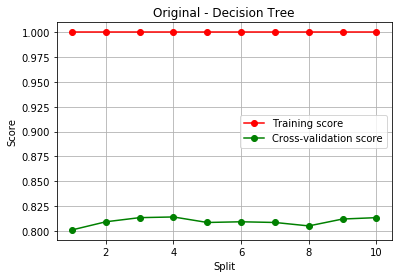

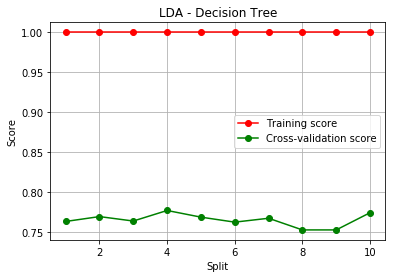

In [76]:
result_original = perform_decision_tree(original_train, original_test, 'Original')
result_lda = perform_decision_tree(lda_train, lda_test, 'LDA')

In [77]:
print("Original: ", result_original)
print("LDA: ", result_lda)

Original:  [0.8087978369384359, 0.004278716398175866, 0.8136439267886856, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')]
LDA:  [0.7632903494176373, 0.003234778130270704, 0.7680948419301165, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')]


In [78]:
def tree_info(model):
    '''
    Obtain informations about the tree.
    '''
    tree = model.tree_
    nodes = tree.node_count    
    children_left = tree.children_left
    children_right = tree.children_right
    leaves = 0
    
    '''
    Perform the walk over tree.
    '''
    def walk(id):
        nonlocal leaves
        if (children_left[id] != children_right[id]):
            left_max = 1 + walk(children_left[id])
            right_max = 1 + walk(children_right[id])
            return max(left_max, right_max)
        else: # leaf
            leaves += 1
            return 1

    root_node_id = 0
    return {'nodes' : nodes, 'height' : walk(root_node_id), 'leaves': leaves}
        

In [79]:
print(tree_info(result_original[3]))
print(tree_info(result_lda[3]))

{'nodes': 3539, 'height': 33, 'leaves': 1770}
{'nodes': 4231, 'height': 32, 'leaves': 2116}


In [84]:
def perform_decision_tree_prune(train, test, title, max_depth):
    '''
    Performs decision tree for a given dataset.
    '''
    # Split the datasets in data and target
    train_target = train['cover_type']
    train_data   = train.loc[:, train.columns != 'cover_type']
    test_target  = test['cover_type']
    test_data    = test.loc[:, test.columns != 'cover_type']
    
    d_tree = DecisionTreeClassifier(random_state=0, max_depth=max_depth)    
    result = cross_validate(d_tree, train_data, train_target, cv=10, return_estimator=True, return_train_score=True)
    
    acc_best = 0
    best_estimator = result['estimator'][0]
    scores = []
    
    plt.figure()
    plt.title(title + ' - Decision Tree (max_depth = ' + str(max_depth) + ')')
    plt.xlabel("Split")
    plt.ylabel("Score")
    plt.plot(range(1,11), result['train_score'], 'o-', color="r", label="Training score")
    plt.plot(range(1,11), result['test_score'], 'o-', color="g", label="Cross-validation score")
    plt.grid()
    plt.legend(loc="best")
    plt.show()
    
    for estimator in result['estimator']:
        score = estimator.score(test_data, test_target)
        scores.append(score)
        if score > acc_best:
            acc_best = score
            best_estimator = estimator
            
    return [np.mean(scores), np.std(scores), np.max(scores), best_estimator]

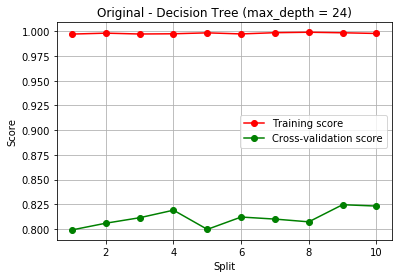

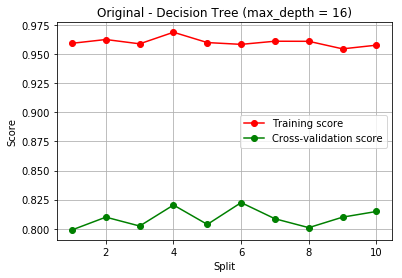

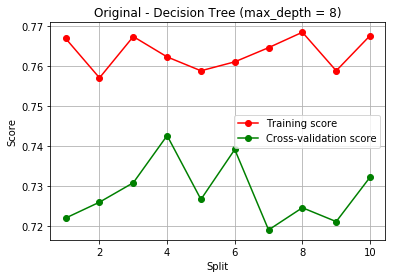

In [85]:
result_original_75 = perform_decision_tree_prune(original_train, original_test, 'Original', 24)
result_original_50 = perform_decision_tree_prune(original_train, original_test, 'Original', 16)
result_original_25 = perform_decision_tree_prune(original_train, original_test, 'Original', 8)


In [86]:
print("Original (75%): ", result_original_75)
print("Original (50%):", result_original_50)
print("Original (25%): ", result_original_25)

Original (75%):  [0.8085274542429284, 0.004356017917328937, 0.8136439267886856, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=24,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')]
Original (50%): [0.8067179700499167, 0.0037159835698105776, 0.812396006655574, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=16,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')]
Original (25%):  [0.7306988352745425, 0.006522165431786895, 0.7396006655574043, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth

In [87]:
print("[INFO] - Original (75%): ", tree_info(result_original_75[3]))
print("[INFO] - Original (50%): ", tree_info(result_original_50[3]))
print("[INFO] - Original (25%): ", tree_info(result_original_25[3]))

[INFO] - Original (75%):  {'nodes': 3391, 'height': 25, 'leaves': 1696}
[INFO] - Original (50%):  {'nodes': 2611, 'height': 17, 'leaves': 1306}
[INFO] - Original (25%):  {'nodes': 375, 'height': 9, 'leaves': 188}


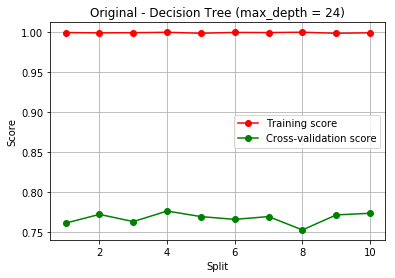

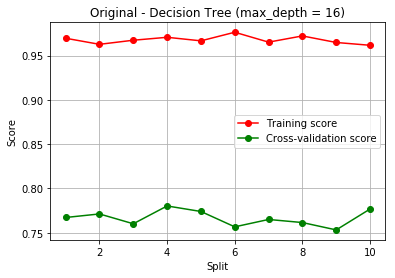

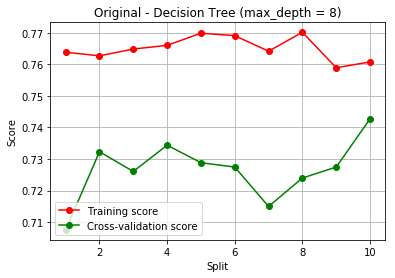

In [88]:
result_lda_75 = perform_decision_tree_prune(lda_train, lda_test, 'LDA', 24)
result_lda_50 = perform_decision_tree_prune(lda_train, lda_test, 'LDA', 16)
result_lda_25 = perform_decision_tree_prune(lda_train, lda_test, 'LDA', 8)


In [89]:
print("LDA (75%): ", result_lda_75)
print("LDA (50%):", result_lda_50)
print("LDA (25%): ", result_lda_25)

LDA (75%):  [0.7633319467554077, 0.0031037440402645394, 0.769134775374376, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=24,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')]
LDA (50%): [0.7638519134775373, 0.004698105791512641, 0.7724625623960066, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=16,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')]
LDA (25%):  [0.7159525790349417, 0.0065455033482467945, 0.7271214642262895, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
          

In [90]:
print("[INFO] - LDA (75%): ", tree_info(result_lda_75[3]))
print("[INFO] - LDA (50%): ", tree_info(result_lda_50[3]))
print("[INFO] - LDA (25%): ", tree_info(result_lda_25[3]))

[INFO] - LDA (75%):  {'nodes': 4209, 'height': 25, 'leaves': 2105}
[INFO] - LDA (50%):  {'nodes': 3459, 'height': 17, 'leaves': 1730}
[INFO] - LDA (25%):  {'nodes': 379, 'height': 9, 'leaves': 190}
